In [1]:
import warnings
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)
from src.generalized_rashomon_set import utils
from src.generalized_rashomon_set import plots
from src.generalized_rashomon_set import explainers
import pandas as pd
import statsmodels.api as sm
%load_ext autoreload
%autoreload 2
%matplotlib inline

2024-01-18 16:59:39,880 INFO config <module> The output directory is /home/sichao/Documents/Projects/generalized_rashomon_set_refactor/experiments/../results
 The log directory is /home/sichao/Documents/Projects/generalized_rashomon_set_refactor/experiments/../logs
2024-01-18 16:59:39,914 INFO config <module> The output directory is /home/sichao/Documents/Projects/generalized_rashomon_set_refactor/experiments/../results
 The log directory is /home/sichao/Documents/Projects/generalized_rashomon_set_refactor/experiments/../logs


# Load dataset and define Logistic regressor from VIC results

In [2]:
from sklearn.model_selection import train_test_split
data = pd.read_csv('../data/Recidivism prediction/compas.csv', usecols=['Age=18-20', 'Race=African-American', 'Prior-Crimes=0','Gender=Male', 'Juvenile-Crimes=0', 'Current-Charge-Degree=Misdemeanor'])
X = data.rename({'Age=18-20':"age", 'Race=African-American':"race", 'Prior-Crimes=0':"prior", 'Gender=Male':"gender", 'Juvenile-Crimes=0':"juvenilecrime", 'Current-Charge-Degree=Misdemeanor':"currentcharge"}, axis='columns')
y = pd.read_csv('../data/Recidivism prediction/compas.csv', usecols=['Recidivate-Within-Two-Years'])
# y[y==0] = -1
vlist = ["age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]
X, y = utils.pd_to_numpy(X, y)
X_added_constant = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X_added_constant, y, random_state = 2020, test_size=0.3)

In [3]:
model_optimal = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.640067
         Iterations 6


In [4]:
from sklearn.metrics import log_loss
model_vic = sm.Logit(y_train, X_train).fit()
coefs = np.array([0.5435123, 1.4684052, 0.3521730, -0.8664713, 0.3207619, -0.8815762, -0.2340473])
for idx, weight in enumerate(coefs):
    model_vic.params[idx] = weight
loss_ref = log_loss(y_train, model_vic.predict(X_train))
print('Loss of the model built from VIC is ', loss_ref)

Optimization terminated successfully.
         Current function value: 0.640067
         Iterations 6
Loss of the model built from VIC is  0.7276876051878167


## Build explainer for VIC comparison

### Feature importance range, comparing with VIC. Noted that they used ratio, so we followed that for comparison using MR
### Same model, same evaluation protocol, different exploring method

In [28]:
fis_reg_vic = explainers.fis_explainer(model_vic,
                                                   X_test, y_test, epsilon_rate=0.05,
                                                   loss_fn='log_loss', n_ways=2, wrapper_for_torch=False, binary=False)

2024-01-18 15:37:45,640 INFO _explainer __init__ You can call function explainer.load_results(results_path="") to load trained results if exist


In [29]:
fis_reg_vic.ref_explain(model_reliance=True)
fis_reg_vic.rset_explain()

2024-01-18 15:37:46,270 INFO _explainer ref_explain Reference model analysis
2024-01-18 15:37:46,271 INFO _explainer ref_explain Calculating main effect, joint effect and FIS for the reference model
2024-01-18 15:37:46,671 INFO _explainer ref_explain main effects calculated and can be called by explainer.ref_analysis[ref_main_effects]
2024-01-18 15:37:46,672 INFO _explainer ref_explain features with importance 0 are excluded, including []
2024-01-18 15:37:47,328 INFO _explainer _get_ref_fis joint effects calculated and can be called by explainer.ref_joint_effects
2024-01-18 15:37:47,329 INFO _explainer ref_explain FIS calculated and can be called by explainer.ref_analysis
2024-01-18 15:37:47,331 INFO _explainer ref_explain Calculation done
2024-01-18 15:37:47,334 INFO _explainer rset_explain Start exploring the possible models
2024-01-18 15:37:47,334 INFO _explainer _explore_m_in_R Searching models in the Rashomon set ...
2024-01-18 15:37:47,337 INFO _explainer _greedy_search Feature 0

In [30]:
# Model reliance function from VIC calculation
def MR(idx, X, y, model):
    loss_before = log_loss(y, model.predict(X))
    p = sum(X[:, idx] == 1) / len(X)
    X[:, idx] = 1
    loss = log_loss(y, model.predict(X)) * p
    X[:, idx] = -1
    loss_after = loss + log_loss(y, model.predict(X)) * (1 - p)
    return loss_after / loss_before

def MR_comparison():
    MR_all_ratio = np.ones((11, 7, 2))
    for i in range(11):
        for j in range(7):
            for k in range(2):
                X0 = X_test.copy()
                X0[:, j] = X0[:, j] * fis_reg_vic.rset_main_effect_processed['m_multi_boundary_e'][i,j,k]
                MR_all_ratio[i, j, k] = MR(j, X0, y_test, fis_reg_vic.model)
    results_vic_comparison = np.zeros((7,4))
    for i in range(7):
        results_vic_comparison[i, 0] = np.max(MR_all_ratio[:, i, :])
        results_vic_comparison[i, 1] = np.min(MR_all_ratio[:, i, :])
        results_vic_comparison[i, 2] = np.max(MR_all_ratio[:, i, :]) - np.min(MR_all_ratio[:, i, :])
        results_vic_comparison[i, 3] = np.mean(MR_all_ratio[:, i, :])
    return results_vic_comparison

In [32]:
results_vic_comparison = MR_comparison()

array([[1.14091298, 1.07563848, 0.06527449, 1.10265893],
       [1.00668956, 0.92409775, 0.08259182, 0.94851706],
       [1.37299595, 1.12280534, 0.25019061, 1.32845921],
       [0.98587356, 0.90394998, 0.08192358, 0.92788989],
       [1.39110573, 1.27831825, 0.11278748, 1.35237183],
       [1.07063893, 1.01965518, 0.05098375, 1.04338934]])

# Halo plot
This can be accumulated by different $\epsilon$, e.g., t = [0.2, ..., 1.0]

In [6]:
fis_reg_optimal = explainers.fis_explainer(model_optimal,
                                       X_test, y_test, epsilon_rate=0.1,
                                       loss_fn='log_loss', n_ways=2, wrapper_for_torch=False, binary=False)
fis_reg_optimal.ref_explain(model_reliance=True)
fis_reg_optimal.rset_explain()

2024-01-18 17:00:42,783 INFO _explainer __init__ You can call function explainer.load_results(results_path="") to load trained results if exist
2024-01-18 17:00:42,785 INFO _explainer ref_explain Reference model analysis
2024-01-18 17:00:42,786 INFO _explainer ref_explain Calculating main effect, joint effect and FIS for the reference model
2024-01-18 17:00:43,162 INFO _explainer ref_explain main effects calculated and can be called by explainer.ref_analysis[ref_main_effects]
2024-01-18 17:00:43,162 INFO _explainer ref_explain features with importance 0 are excluded, including []
2024-01-18 17:00:43,735 INFO _explainer _get_ref_fis joint effects calculated and can be called by explainer.ref_joint_effects
2024-01-18 17:00:43,736 INFO _explainer ref_explain FIS calculated and can be called by explainer.ref_analysis
2024-01-18 17:00:43,736 INFO _explainer ref_explain Calculation done
2024-01-18 17:00:43,739 INFO _explainer rset_explain Start exploring the possible models
2024-01-18 17:00:

In [7]:
fis_reg_optimal_0 = explainers.fis_explainer(model_optimal,
                                       X_test, y_test, epsilon_rate=0.02,
                                       loss_fn='log_loss', n_ways=2, wrapper_for_torch=False, binary=False)
fis_reg_optimal_0.ref_explain(model_reliance=True)
fis_reg_optimal_0.rset_explain()

2024-01-18 17:02:44,569 INFO _explainer __init__ You can call function explainer.load_results(results_path="") to load trained results if exist
2024-01-18 17:02:44,572 INFO _explainer ref_explain Reference model analysis
2024-01-18 17:02:44,572 INFO _explainer ref_explain Calculating main effect, joint effect and FIS for the reference model
2024-01-18 17:02:44,975 INFO _explainer ref_explain main effects calculated and can be called by explainer.ref_analysis[ref_main_effects]
2024-01-18 17:02:44,975 INFO _explainer ref_explain features with importance 0 are excluded, including []
2024-01-18 17:02:45,539 INFO _explainer _get_ref_fis joint effects calculated and can be called by explainer.ref_joint_effects
2024-01-18 17:02:45,540 INFO _explainer ref_explain FIS calculated and can be called by explainer.ref_analysis
2024-01-18 17:02:45,540 INFO _explainer ref_explain Calculation done
2024-01-18 17:02:45,542 INFO _explainer rset_explain Start exploring the possible models
2024-01-18 17:02:

In [8]:
fis_reg_optimal_1 = explainers.fis_explainer(model_optimal,
                                       X_test, y_test, epsilon_rate=0.04,
                                       loss_fn='log_loss', n_ways=2, wrapper_for_torch=False, binary=False)
fis_reg_optimal_1.ref_explain(model_reliance=True)
fis_reg_optimal_1.rset_explain()

In [9]:
fis_reg_optimal_2 = explainers.fis_explainer(model_optimal,
                                       X_test, y_test, epsilon_rate=0.06,
                                       loss_fn='log_loss', n_ways=2, wrapper_for_torch=False, binary=False)
fis_reg_optimal_2.ref_explain(model_reliance=True)
fis_reg_optimal_2.rset_explain()

In [10]:
fis_reg_optimal_3 = explainers.fis_explainer(model_optimal,
                                       X_test, y_test, epsilon_rate=0.08,
                                       loss_fn='log_loss', n_ways=2, wrapper_for_torch=False, binary=False)
fis_reg_optimal_3.ref_explain(model_reliance=True)
fis_reg_optimal_3.rset_explain()


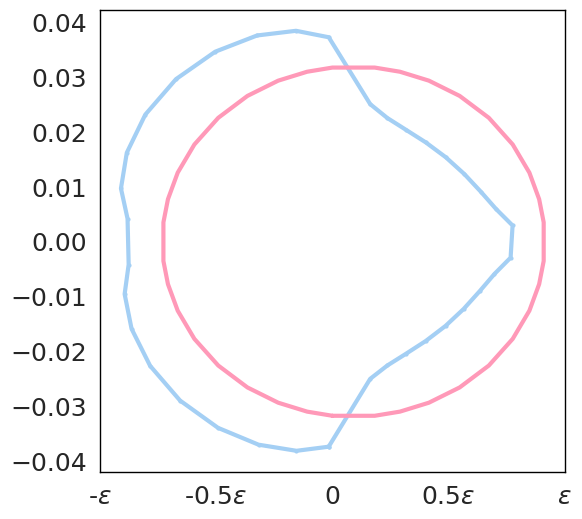

In [44]:
plots.halo_plot(fis_reg_optimal, 16)

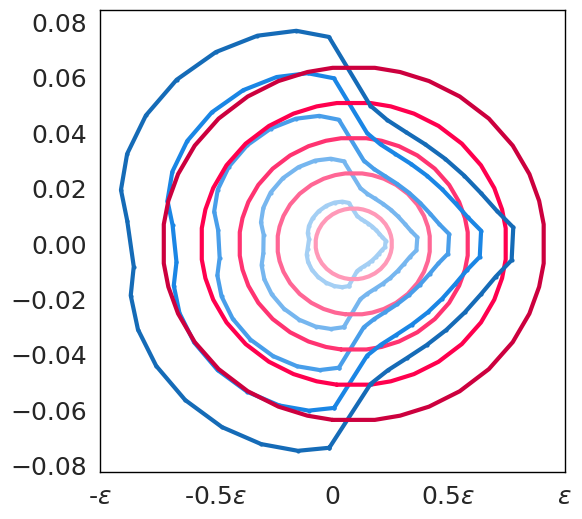

In [29]:
plots.halo_plot_multiple(fis_reg_optimal_0, fis_reg_optimal_1, fis_reg_optimal_2, fis_reg_optimal_3, fis_reg_optimal, pair_idx=16)

# Swarm plot
this can be either absolute value or relative value

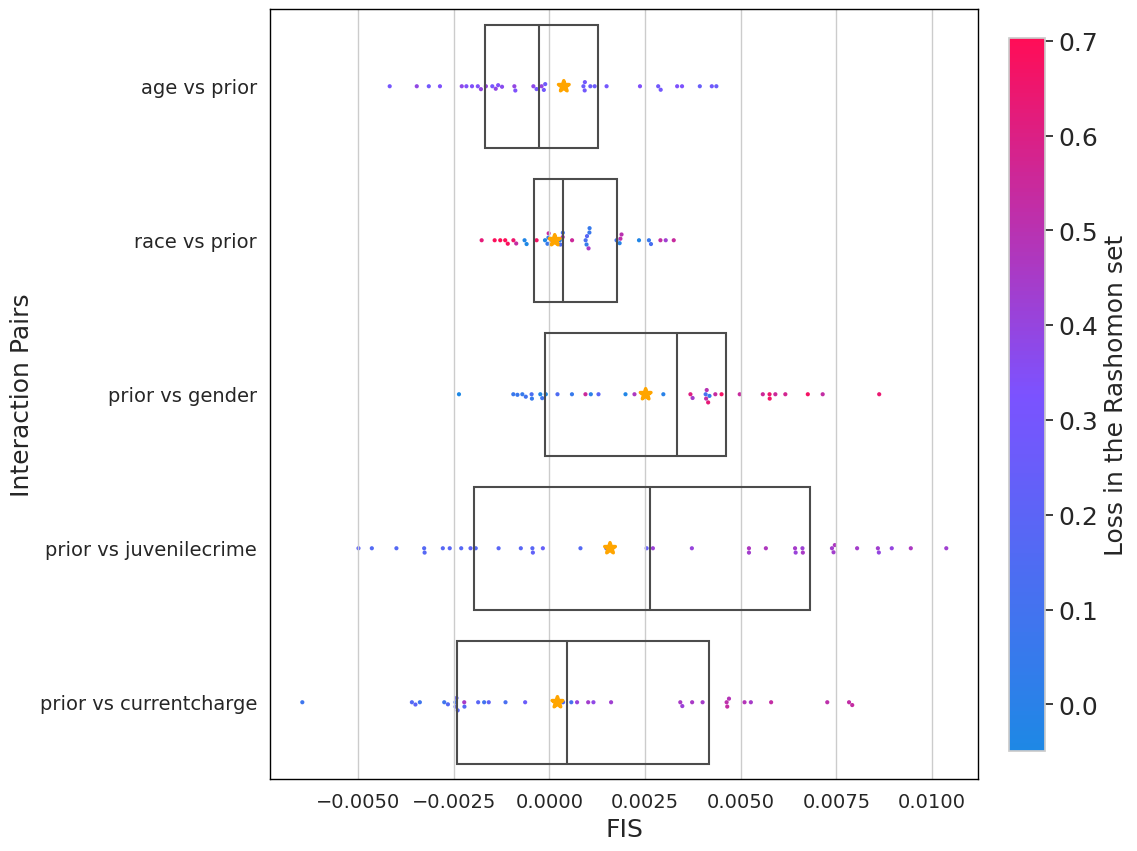

In [39]:
interest_pairs = [(1,3), (2,3) , (3,4), (3,5), (3,6)]
vlist_intercept = ["intercept", "age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]
plots.swarm_plot_FIS(fis_reg_optimal, interest_pairs, vname=vlist_intercept, plot_all=False, threshold=None, boxplot=True, save=False, absolute=False,
                   suffix=None)

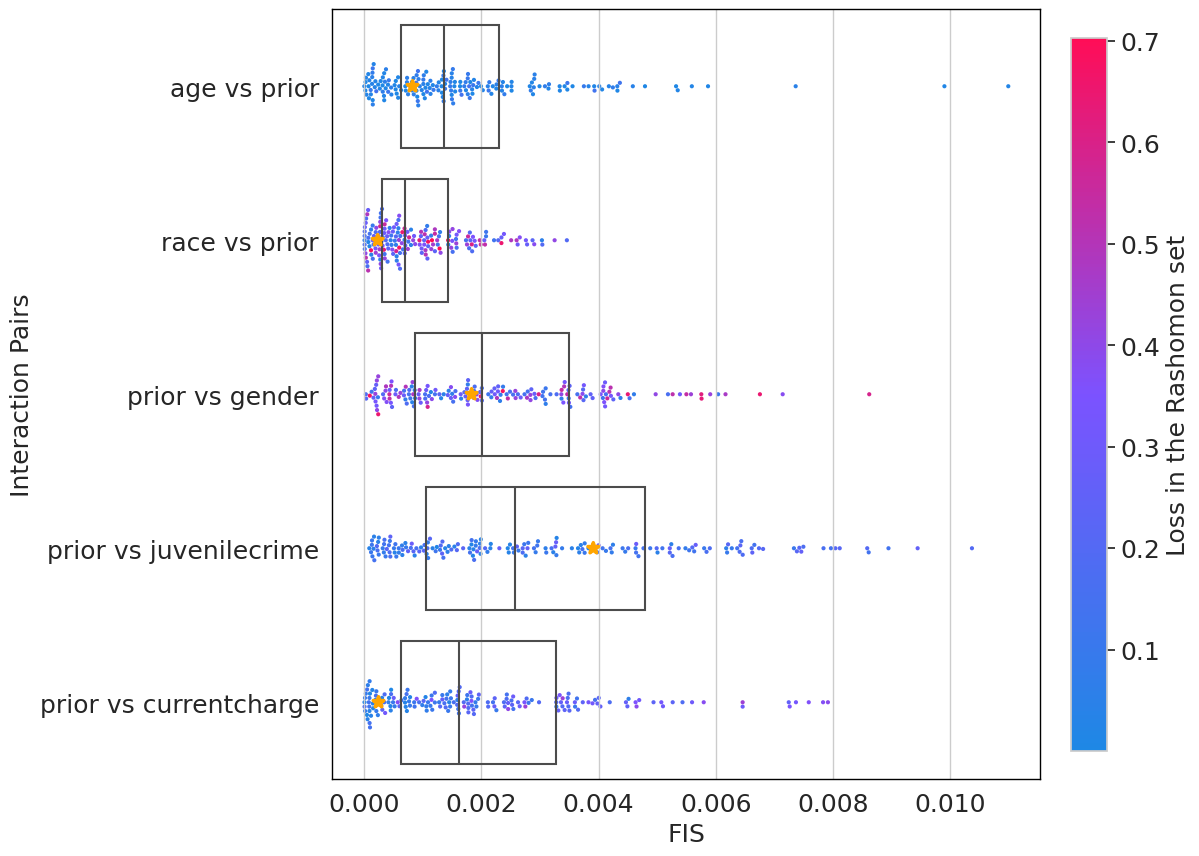

In [43]:
interest_pairs = [(1,3), (2,3) , (3,4), (3,5), (3,6)]
vlist_intercept = ["intercept", "age", "race", "prior", "gender", "juvenilecrime", "currentcharge"]
plots.swarm_plot_FIS_multiple(fis_reg_optimal_0, fis_reg_optimal_1, fis_reg_optimal_2, fis_reg_optimal_3, fis_reg_optimal, interest_of_pairs=interest_pairs, vname=vlist_intercept, plot_all=False, threshold=None, boxplot=True, save=False, absolute=True)

### 3D halo plot

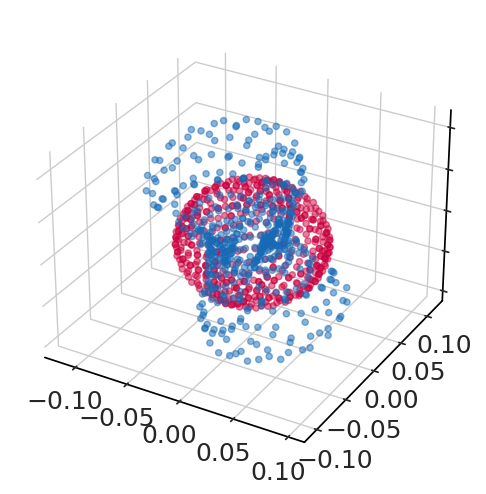

In [77]:
plots.halo_plot_3D(fis_reg_optimal, (3,4,5), save=False, path='')

# Add another dimension for color information to halo plot
There exists other ways of integrating 4-th dimension information into halo plot, and we only show the possibility of color to represent the 4-th dimension information

In [88]:
from src.generalized_rashomon_set.utils import find_all_sum_to_one_pairs
import itertools
def high_order_vis_loss(loss_emp_all, boundary, n_ways, loss_ref, loss_others_1, loss_others_2, loss_others_3):
    loss_main_all = np.arange(0, 1+0.1, 0.1) * boundary
    cord_loss = []
    circle = []
    sum_to_one_pairs = find_all_sum_to_one_pairs(n_ways)
    quadrants = {}
    colors_inf = []
    for idx, i in enumerate(itertools.product([1, -1], repeat=n_ways)):
        quadrants[idx] = i
    for idx, pair in enumerate(sum_to_one_pairs):
        cosa = pair[0] / (np.sqrt(pair[0] ** 2 + pair[1] ** 2 + pair[2] ** 2))
        cosb = pair[1] / (np.sqrt(pair[0] ** 2 + pair[1] ** 2 + pair[2] ** 2))
        cosc = pair[2] / (np.sqrt(pair[0] ** 2 + pair[1] ** 2 + pair[2] ** 2))
        dega = np.arccos(cosa)
        degb = np.arccos(cosb)
        degc = np.arccos(cosc)
        for quadrant in quadrants:
            main_loss_sum = loss_main_all[pair[0]] + loss_main_all[pair[1]] + loss_main_all[pair[2]]
            circle.append(
                [main_loss_sum * np.cos(dega) * quadrants[quadrant][0], main_loss_sum * np.cos(degb)* quadrants[quadrant][1] , main_loss_sum * np.cos(degc)* quadrants[quadrant][2]])
            interaction_effect = loss_emp_all[idx * pow(2, n_ways) + quadrant] - loss_ref
            interaction_effect_1 = loss_others_1[idx * pow(2, n_ways) + quadrant] - loss_ref
            interaction_effect_2 = loss_others_2[idx * pow(2, n_ways) + quadrant] - loss_ref
            interaction_effect_3 = loss_others_3[idx * pow(2, n_ways) + quadrant] - loss_ref
            cord_loss.append(
                [interaction_effect * np.cos(dega)* quadrants[quadrant][0], interaction_effect * np.cos(degb)* quadrants[quadrant][1], interaction_effect * np.cos(degc)* quadrants[quadrant][2]])
            colors_inf.append((interaction_effect_1+interaction_effect_2+interaction_effect_3)/3)
    return circle, cord_loss, colors_inf

In [82]:
pair_idx = (4,5,6)
_, loss_emp_three = fis_reg_optimal.fis_attributor.feature_interaction_effect(pair_idx, fis_reg_optimal.rset_main_effect_processed['m_multi_boundary_e'].transpose((1, 0, 2)), fis_reg_optimal.input, fis_reg_optimal.output,subset_idx=pair_idx)
pair_idx = (3,4,5)
_, loss_emp_three_1 = fis_reg_optimal.fis_attributor.feature_interaction_effect(pair_idx, fis_reg_optimal.rset_main_effect_processed['m_multi_boundary_e'].transpose((1, 0, 2)), fis_reg_optimal.input, fis_reg_optimal.output,subset_idx=pair_idx)
pair_idx = (3,4,6)
_, loss_emp_three_2 = fis_reg_optimal.fis_attributor.feature_interaction_effect(pair_idx, fis_reg_optimal.rset_main_effect_processed['m_multi_boundary_e'].transpose((1, 0, 2)), fis_reg_optimal.input, fis_reg_optimal.output,subset_idx=pair_idx)
pair_idx = (3,5,6)
_, loss_emp_three_3 = fis_reg_optimal.fis_attributor.feature_interaction_effect(pair_idx, fis_reg_optimal.rset_main_effect_processed['m_multi_boundary_e'].transpose((1, 0, 2)), fis_reg_optimal.input, fis_reg_optimal.output,subset_idx=pair_idx)

In [89]:
circle, cord_loss, colors_inf = high_order_vis_loss(loss_emp_three, fis_reg_optimal.epsilon, 3, fis_reg_optimal.loss, loss_emp_three_1, loss_emp_three_2, loss_emp_three_3)

/tmp/ipykernel_1487012/2676283783.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(sm, fraction=0.046, pad=0.06)


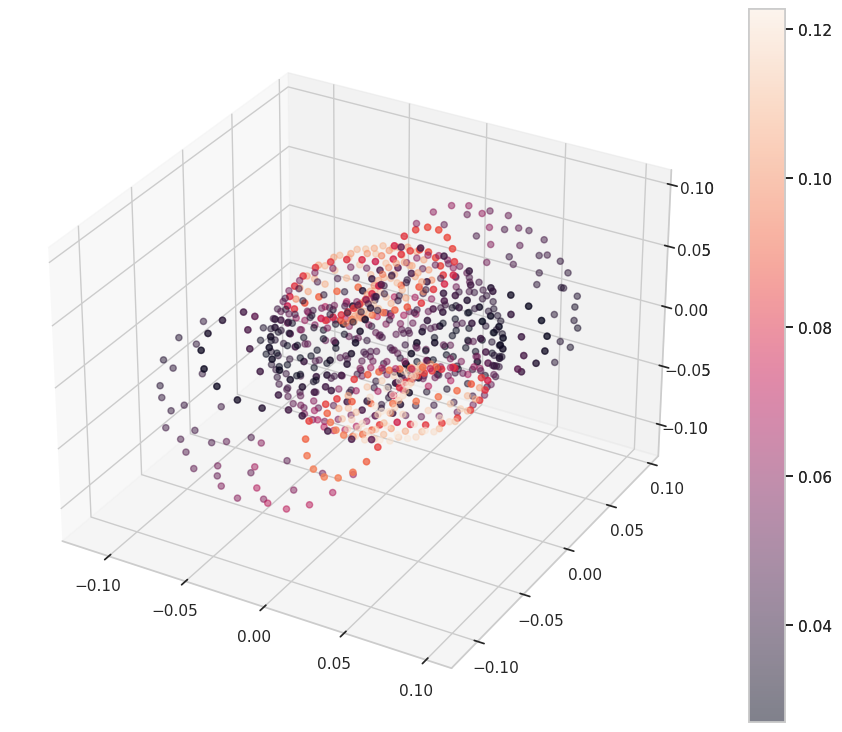

In [91]:
from matplotlib import pyplot as plt
ax = plt.axes(projection='3d')
ball_exp = np.array(circle)
ball_emp = np.array(cord_loss)
sm = ax.scatter(ball_emp[:, 0], ball_emp[:, 1], ball_emp[:, 2], c=np.array(colors_inf), label='emperial interaction', alpha=.5)
ax.scatter(ball_exp[:,0], ball_exp[:,1], ball_exp[:,2], c=np.array(colors_inf), label='expected interaction', alpha=.5)
ax.figure.colorbar(sm, fraction=0.046, pad=0.06)
plt.show()
# plt.savefig('age_prior_race_gender.png', bbox_inches='tight')